# Image Search Engine
[GitHub](https://github.com/a-tabaza/)

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob

In [ ]:
paths = glob("/content/drive/MyDrive/Ran Frames/*.jpg") + glob("/content/drive/MyDrive/Ran Frames/*.jpeg") + glob("/content/drive/MyDrive/Ran Frames/*.png")

In [ ]:
paths[:5]

['/content/drive/MyDrive/Ran Frames/1409.jpg',
 '/content/drive/MyDrive/Ran Frames/1412.jpg',
 '/content/drive/MyDrive/Ran Frames/1414.jpg',
 '/content/drive/MyDrive/Ran Frames/1413.jpg',
 '/content/drive/MyDrive/Ran Frames/1416.jpg']

## Modelling

In [ ]:
%pip install faiss-cpu open_clip_torch Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 814.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from PIL import Image
import open_clip
import faiss
import numpy as np
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
def load_model():
  model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
  tokenizer = open_clip.get_tokenizer('ViT-B-32')
  return model, preprocess, tokenizer

In [ ]:
model, preprocess, tokenizer = load_model()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
def embed_image(image_path):
  img = Image.open(image_path)
  if img.mode != "RGB":
        img = img.convert("RGB")
  image = preprocess(img).unsqueeze(0)
  image_features = model.encode_image(image, normalize=True).numpy(force=True)
  return image_features.squeeze(0)

In [ ]:
embed_image(paths[0]).shape

(512,)

In [ ]:
def embed_text(text):
  tokenized_text = tokenizer([text])
  text_features = model.encode_text(tokenized_text, normalize=True).numpy(force=True)
  return text_features.squeeze(0)

In [ ]:
def create_index():
  index = faiss.IndexFlatL2(512)
  return index

In [ ]:
index = create_index()

In [ ]:
embeddings = [embed_image(path) for path in tqdm(paths)]

100%|██████████| 2410/2410 [25:25<00:00,  1.58it/s]


In [ ]:
def add_embeddings(embeddings_array):
  index.add(np.array(embeddings_array).astype('float32'))

In [ ]:
add_embeddings(embeddings)

In [ ]:
def search_index_text(text_query, k=10):
  query_emb = embed_text(text_query)
  D, I = index.search(query_emb.reshape(1, -1), k)
  return I[0].tolist()

In [ ]:
def search_index_image(image_query, k=10):
  query_emb = embed_image(image_query)
  D, I = index.search(query_emb.reshape(1, -1), k)
  return I[0].tolist()

In [ ]:
results = search_index_text(input("Input your search query."))

Input your search query.Man fighting in a war, with blood everywhere


In [ ]:
def show_images(image_idx):
  for indx in image_idx:
    indx_path = paths[indx]
    img = cv2.imread(indx_path)
    cv2_imshow(img)


What do you want?yellow


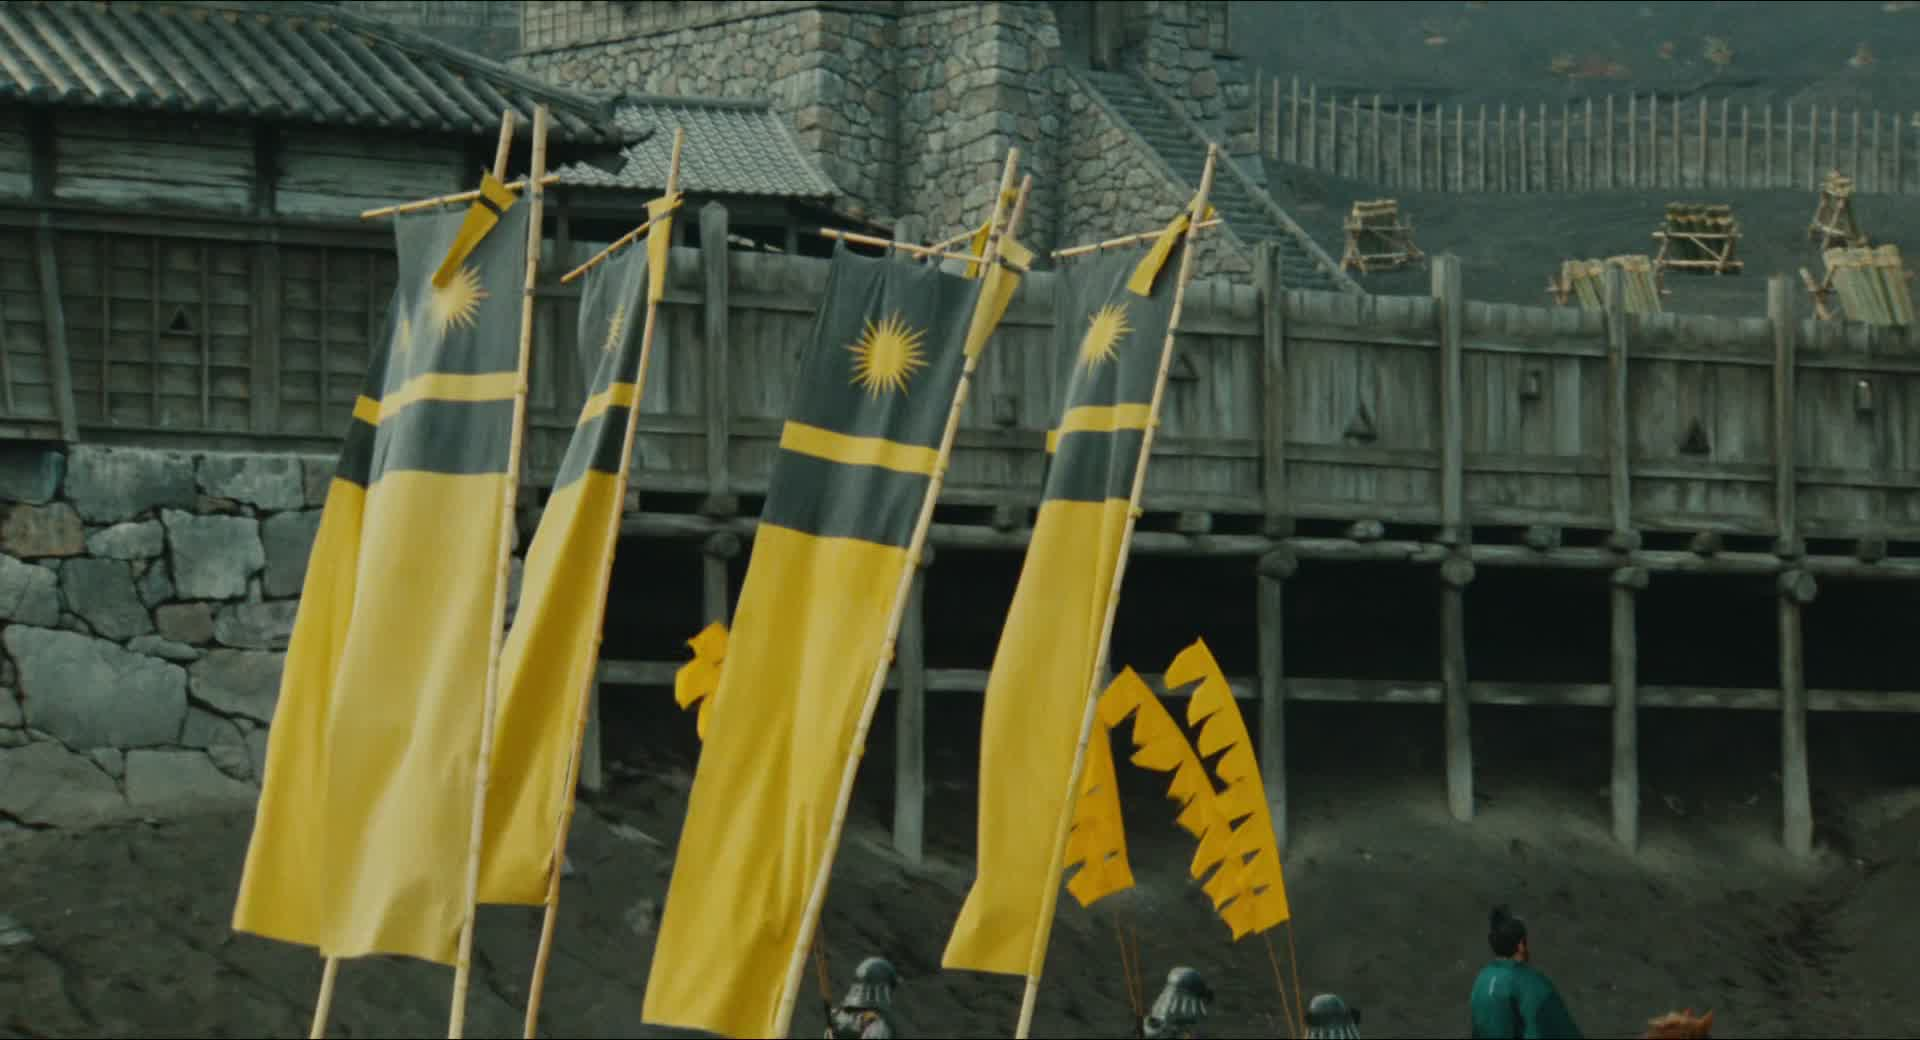

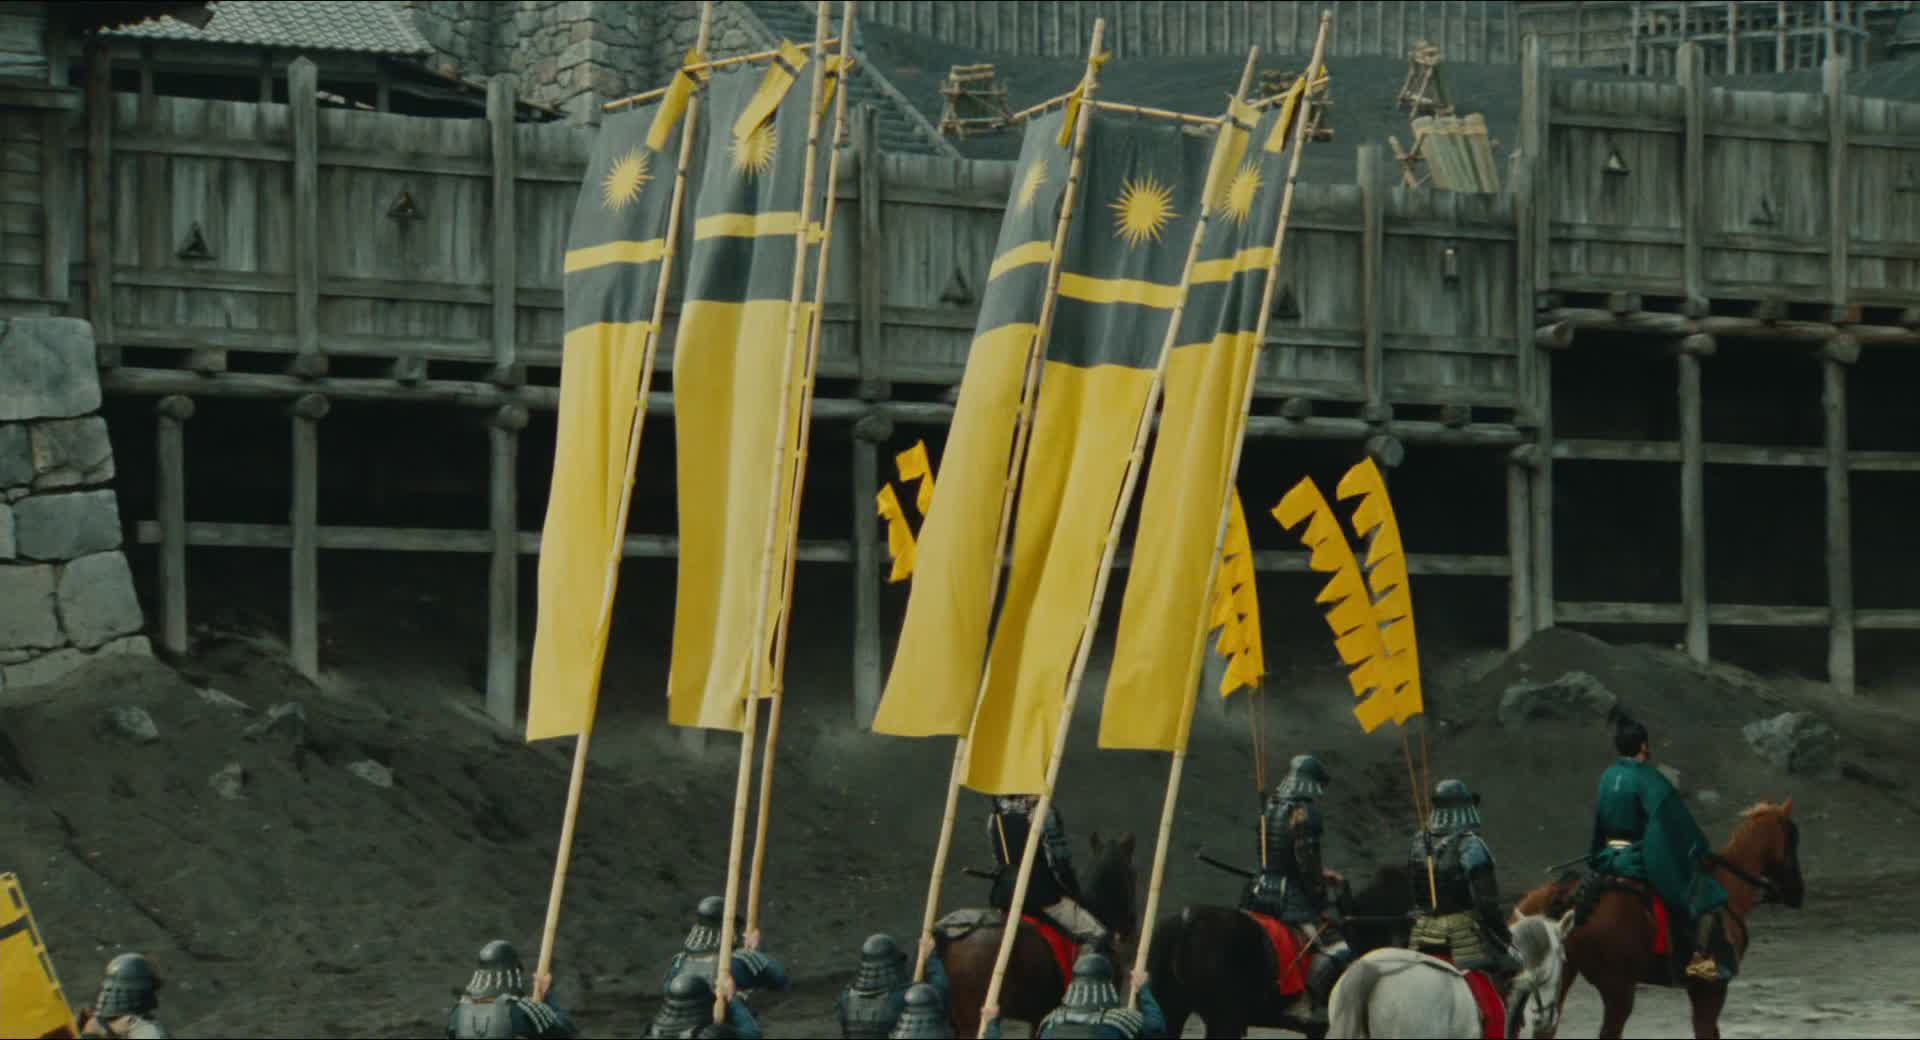

In [ ]:
show_images(search_index_text(input("What do you want?"), k=2))